### **Somatic Variant Calling on ATAC-seq Data with GATK4**
### Description
This notebook documents the workflow for doing somatic variant calling on ATAC-seq data with GATK4.


1. First, prepare *bed* files containing regions of interest to call mutations across.

2. There are prerequisite files that are required for the pipeline. Thankfully, they are available on Odin. Below are the list of files:
    * reference genome with fasta index (.fai)

    * gnomAD vcf files and tabix index (.tbi)

3. Next, as we are working on TCGA datasets that only have mapped BAM files available, files called unmapped BAMs (uBAMs) need to be generated prior to GATK processing.

---

## Data Pre-Processing

First, generate a sequence dictionary file from the reference genome to be used for the workflow using GATK's `CreateSequenceDictionary` tool. Then we also need to index the reference genome with BWA's `bwa index` to generate a reference database for BWA alignment.

In [6]:
%%bash
qsub /home/users/ntu/suffiazi/scripts/gatk-workflow-scripts/scripts/gatk-create_seqdict_index_ref.pbs

2860601.pbs101


### 1. Fix Read Groups

First we need to decide which input files to use for the analysis. For this analysis, we will be using mapped bam files produced by the ENCODE ATAC-seq pipeline. GATK requires an unmapped BAM (or FASTQ) with properly assigned read groups (@RG) in order to run. So first we will check for read groups in the mapped BAM files that we have, and add RG IDs to them if they are missing.

1. Run the bash script below to check for read groups in the mapped BAM files.


In [5]:
%%bash
# find all bam_list.txt files in the bam list directory
readarray -t lists < <(find /scratch/users/ntu/suffiazi/inputs/mpileup_list -name "*.txt" -type f)
echo "Bam file lists loaded: "
for item in "${lists[@]}"; do
    echo "${item}"
done

for list in "${lists[@]}"; do
    echo "Processing list: $list"
    # get bam file path from the text file per line and store in an array
    readarray -t bams < "$list"
    for bam in "${bams[@]}"; do
        echo "Processing bam: $bam"
        samtools view -H "$bam" | grep '^@RG'
    done
done

Bam file lists loaded: 
/scratch/users/ntu/suffiazi/inputs/mpileup_list/PU24GB8.bam-list.txt
/scratch/users/ntu/suffiazi/inputs/mpileup_list/2GAMBDQ.bam-list.txt
/scratch/users/ntu/suffiazi/inputs/mpileup_list/S6R691V.bam-list.txt
/scratch/users/ntu/suffiazi/inputs/mpileup_list/ANAB5F7.bam-list.txt
/scratch/users/ntu/suffiazi/inputs/mpileup_list/98JKPD8.bam-list.txt
Processing list: /scratch/users/ntu/suffiazi/inputs/mpileup_list/PU24GB8.bam-list.txt
Processing bam: /home/users/ntu/suffiazi/scratch/inputs/atac-croo-out/PU24GB8/sample5/3fc5414d-9d6e-43ef-8816-41fc2acb65fc.nodup.no_chrM_MT.bam
@RG	ID:HLHYHBBXX_3_BRCA-CA5AB738-9366-4908-B573-92C041E15471-X020-S05-L010-B1-T2-P050_TCGA-C8-A12Y-01A-31-A615-42	CN:SFGF	LB:BRCA-CA5AB738-9366-4908-B573-92C041E15471-X020-S05-L010-B1-T2-P050	PL:ILLUMINA	PM:Illumina HiSeq 4000	PU:HLHYHBBXX.3.TGGGTTTC+GCAGTCCG	SM:TCGA-C8-A12Y-01A-31-A615-42-X020-S05_aliquot
@RG	ID:HLHYHBBXX_5_BRCA-CA5AB738-9366-4908-B573-92C041E15471-X020-S05-L009-B1-T1-P052_TCGA-C8

2. If there are missing @RG fields or no @RG information at all, they need to be added. We can use GATK4 `AddOrReplaceReadGroups` to do this.

In [ ]:
%%bash
java -jar picard.jar AddOrReplaceReadGroups \
    INPUT=reads.bam \
    OUTPUT=reads_addRG.bam \
    RGID=H0164.2 \ #be sure to change from default of 1
    RGLB=library1 \
    RGPL=illumina \
    RGPU=H0164ALXX140820.2 \
    RGSM=sample1 \
    CREATE_INDEX=True \
    VERBOSITY=WARNING \
    SORT_ORDER=coordinate \
    CREATE_INDEX=true \
    TMP_DIR=/scratch/tmp
done

3. However, for this set of BRCA data, there is no need for this step as the mapped BAM files already have @RG information. These indexed and sorted BAM files can then be converted to unmapped BAM format (uBAM) using GATK `RevertSam` before being marked for duplicate reads. To convert to uBAM, run the following command:


In [2]:
%%bash

# find all bam_list.txt files in the bam list directory
readarray -t lists < <(find /scratch/users/ntu/suffiazi/inputs/mpileup_list -name "*.txt" -type f)
echo "Bam file lists loaded: "
for item in "${lists[@]}"; do
    echo "${item}"
done

# path prefix for singularity
mount_prefix="/mnt"
# path prefix to be replaced in the bam file path
pattern="/home/users/ntu/suffiazi/scratch"

for list in "${lists[@]}"; do
    echo "Processing list: $list"
    # get bam file path from the text file per line and store in an array
    readarray -t bams < "$list"
    for bam in "${bams[@]}"; do
        echo "Processing bam: $bam"
        modified_bam_path="${bam/#$pattern/$mount_prefix}"
        file_prefix="${modified_bam_path%.*}"
        echo "Modified bam path: $modified_bam_path"
        echo "File prefix: $file_prefix"
        qsub -v BAMFILE="$modified_bam_path",PREFIX="$file_prefix" /home/users/ntu/suffiazi/scripts/gatk-workflow-scripts/scripts/gatk-revert_sam.pbs    
    done
done

Bam file lists loaded: 
/scratch/users/ntu/suffiazi/inputs/mpileup_list/PU24GB8.bam-list.txt
/scratch/users/ntu/suffiazi/inputs/mpileup_list/2GAMBDQ.bam-list.txt
/scratch/users/ntu/suffiazi/inputs/mpileup_list/S6R691V.bam-list.txt
/scratch/users/ntu/suffiazi/inputs/mpileup_list/ANAB5F7.bam-list.txt
/scratch/users/ntu/suffiazi/inputs/mpileup_list/98JKPD8.bam-list.txt
Processing list: /scratch/users/ntu/suffiazi/inputs/mpileup_list/PU24GB8.bam-list.txt
Processing bam: /home/users/ntu/suffiazi/scratch/inputs/atac-croo-out/PU24GB8/sample5/3fc5414d-9d6e-43ef-8816-41fc2acb65fc.nodup.no_chrM_MT.bam
Modified bam path: /mnt/inputs/atac-croo-out/PU24GB8/sample5/3fc5414d-9d6e-43ef-8816-41fc2acb65fc.nodup.no_chrM_MT.bam
File prefix: /mnt/inputs/atac-croo-out/PU24GB8/sample5/3fc5414d-9d6e-43ef-8816-41fc2acb65fc.nodup.no_chrM_MT
2859662.pbs101
Processing bam: /home/users/ntu/suffiazi/scratch/inputs/atac-croo-out/PU24GB8/sample6/a5017f04-4c69-46c6-9b18-8be399a6b85f.nodup.no_chrM_MT.bam
Modified bam p

### 2. Mark Illumina Adapters with XT Tags
MarkIlluminaAdapters adds the XT tag to a read record to mark the 5' start position of the specified adapter sequence and produces a metrics file. Some of the marked adapters come from concatenated adapters that randomly arise from the primordial soup that is a PCR reaction. Others represent read-through to 3' adapter ends of reads and arise from insert sizes that are shorter than the read length. This tag is required for downstream processing to get a clean BAM file.

In [4]:
%%bash

# find all bam_list.txt files in the bam list directory
readarray -t lists < <(find /scratch/users/ntu/suffiazi/inputs/mpileup_list -name "*.txt" -type f)
echo "Bam file lists loaded: "
for item in "${lists[@]}"; do
    echo "${item}"
done

# path prefix for singularity
mount_prefix="/mnt"
# path prefix to be replaced in the bam file path
pattern="/home/users/ntu/suffiazi/scratch"

for list in "${lists[@]}"; do
    echo "Processing list: $list"
    # get bam file path from the text file per line and store in an array
    readarray -t bams < "$list"
    for bam in "${bams[@]}"; do
        echo "Processing bam: $bam"
        dir_path=$(dirname "$bam")
        # find revertsam bam files in each dir_path 
        readarray -t revert_sams < <(find "$dir_path" -name "*revertsam-noXS.bam" -type f)
        for revertsam in "${revert_sams[@]}"; do
            echo "Processing revertsam: $revertsam"
            modified_bam_path="${revertsam/#$pattern/$mount_prefix}"
            echo "Modified bam path: $modified_bam_path"
            file_prefix="${modified_bam_path%.*}"
            echo "File prefix: $file_prefix"
            qsub -v BAMFILE="$modified_bam_path",PREFIX="$file_prefix" /home/users/ntu/suffiazi/scripts/gatk-workflow-scripts/scripts/gatk-mark_illumina_adapters.pbs
        done
    done
done

# run the code below to submit marking adapter jobs under one long job on PBS
# qsub /home/users/ntu/suffiazi/scripts/gatk-workflow-scripts/scripts/gatk-mark_illumina_adapters_batch.pbs

Bam file lists loaded: 
/scratch/users/ntu/suffiazi/inputs/mpileup_list/PU24GB8.bam-list.txt
/scratch/users/ntu/suffiazi/inputs/mpileup_list/2GAMBDQ.bam-list.txt
/scratch/users/ntu/suffiazi/inputs/mpileup_list/S6R691V.bam-list.txt
/scratch/users/ntu/suffiazi/inputs/mpileup_list/ANAB5F7.bam-list.txt
/scratch/users/ntu/suffiazi/inputs/mpileup_list/98JKPD8.bam-list.txt
Processing list: /scratch/users/ntu/suffiazi/inputs/mpileup_list/PU24GB8.bam-list.txt
Processing bam: /home/users/ntu/suffiazi/scratch/inputs/atac-croo-out/PU24GB8/sample5/3fc5414d-9d6e-43ef-8816-41fc2acb65fc.nodup.no_chrM_MT.bam
Processing revertsam: /home/users/ntu/suffiazi/scratch/inputs/atac-croo-out/PU24GB8/sample5/3fc5414d-9d6e-43ef-8816-41fc2acb65fc.nodup.no_chrM_MT_revertsam-noXS.bam
Modified bam path: /mnt/inputs/atac-croo-out/PU24GB8/sample5/3fc5414d-9d6e-43ef-8816-41fc2acb65fc.nodup.no_chrM_MT_revertsam-noXS.bam
File prefix: /mnt/inputs/atac-croo-out/PU24GB8/sample5/3fc5414d-9d6e-43ef-8816-41fc2acb65fc.nodup.no_c

### 3. Align Reads with BWA-MEM & Merge with uBAM Using MergeBamAlignment
After marking adapters on the unmapped BAM files, the reads in the uBAMs can now be mapped to reference genome again, and the mapped reads can be merged with the unmapped reads using MergeBamAlignment. This step requires piping three different tools to save storage space.

In [21]:
%%bash
# first let's run the test script on one BAM file to see if it works
qsub /home/users/ntu/suffiazi/scripts/gatk-workflow-scripts/scripts/customs/gatk-pipe_fq-bwa-mergebam-test.pbs

2870740.pbs101


Now, the batch script for the alignment step can be run, if the test script above is successful. The batch script is below:

In [10]:
%%bash

# find all bam_list.txt files in the bam list directory
readarray -t lists < <(find /scratch/users/ntu/suffiazi/inputs/mpileup_list -name "*.txt" -type f)
echo "Bam file lists loaded: "
for item in "${lists[@]}"; do
    echo "${item}"
done

# path prefix for singularity
mount_prefix="/mnt"
# path prefix to be replaced in the bam file path
pattern="/home/users/ntu/suffiazi/scratch"

for list in "${lists[@]}"; do
    echo "Processing list: $list"
    # get bam file path from the text file per line and store in an array
    readarray -t bams < "$list"
    for bam in "${bams[@]}"; do
        if [[ $bam == *"b0dde559-618f-43ce-9ccf-66c744f8e831.nodup.no_chrM_MT.bam" ]]; then
            echo "Skipping this bam: $bam"
            continue
        fi
        echo "Processing bam: $bam"
        modified_bam_path="${bam/#$pattern/$mount_prefix}"
        echo "Modified bam path: $modified_bam_path"
        file_prefix="${modified_bam_path%.*}"
        echo "File prefix: $file_prefix"
        qsub -v PREFIX="$file_prefix" /home/users/ntu/suffiazi/scripts/gatk-workflow-scripts/scripts/gatk-pipe_fq-bwa-mergebam.pbs
    done
done


Bam file lists loaded: 
/scratch/users/ntu/suffiazi/inputs/mpileup_list/PU24GB8.bam-list.txt
/scratch/users/ntu/suffiazi/inputs/mpileup_list/2GAMBDQ.bam-list.txt
/scratch/users/ntu/suffiazi/inputs/mpileup_list/S6R691V.bam-list.txt
/scratch/users/ntu/suffiazi/inputs/mpileup_list/ANAB5F7.bam-list.txt
/scratch/users/ntu/suffiazi/inputs/mpileup_list/98JKPD8.bam-list.txt
Processing list: /scratch/users/ntu/suffiazi/inputs/mpileup_list/PU24GB8.bam-list.txt
Processing bam: /home/users/ntu/suffiazi/scratch/inputs/atac-croo-out/PU24GB8/sample5/3fc5414d-9d6e-43ef-8816-41fc2acb65fc.nodup.no_chrM_MT.bam
Modified bam path: /mnt/inputs/atac-croo-out/PU24GB8/sample5/3fc5414d-9d6e-43ef-8816-41fc2acb65fc.nodup.no_chrM_MT.bam
File prefix: /mnt/inputs/atac-croo-out/PU24GB8/sample5/3fc5414d-9d6e-43ef-8816-41fc2acb65fc.nodup.no_chrM_MT
2870141.pbs101
Processing bam: /home/users/ntu/suffiazi/scratch/inputs/atac-croo-out/PU24GB8/sample6/a5017f04-4c69-46c6-9b18-8be399a6b85f.nodup.no_chrM_MT.bam
Modified bam p

Now the output bam files are now considered 'clean' BAMs for GATK downstream processing. The next step is to mark duplicate reads using GATK `MarkDuplicatesSpark`.

### 4. Mark Duplicates
The resulting merged bam file from the piped commands above can now be marked for duplicate reads using GATK `MarkDuplicatesSpark`. This step is required for GATK to run properly.

In [28]:
%%bash

# find all bam_list.txt files in the bam list directory
readarray -t lists < <(find /scratch/users/ntu/suffiazi/inputs/mpileup_list -name "*.txt" -type f)
echo "Bam file lists loaded: "
for item in "${lists[@]}"; do
    echo "${item}"
done

# path prefix for singularity
mount_prefix="/mnt"
# path prefix to be replaced in the bam file path
pattern="/home/users/ntu/suffiazi/scratch"

for list in "${lists[@]}"; do
    echo "Processing list: $list"
    # get bam file path from the text file per line and store in an array
    readarray -t bams < "$list"
    for bam in "${bams[@]}"; do
        if [[ $bam == *"860c85db-e39e-4c94-a163-9f4e52ca1054.nodup.no_chrM_MT.bam" || $bam == *"539b824f-690b-488e-a505-3a2639bfbe1c.nodup.no_chrM_MT.bam" || $bam == *"3620b8d9-ba30-4f68-8d0a-8e2aadbbbe01.nodup.no_chrM_MT.bam" || $bam == *"1d357103-3737-4f5b-be13-9ba00da547e0.nodup.no_chrM_MT.bam" || $bam == *"430a0179-12b4-4e9a-bcd1-85861283cd98.nodup.no_chrM_MT.bam" || $bam == *"1b0b67dc-85c5-4ffb-8255-c296141b150d.nodup.no_chrM_MT.bam" || $bam == *"9f5bf096-2786-4025-b972-78d4bd94aed1.nodup.no_chrM_MT.bam" ]]; then
            echo "Skipping this bam: $bam"
            continue
        fi
        echo "Processing bam: $bam"
        modified_bam_path="${bam/#$pattern/$mount_prefix}"
        echo "Modified bam path: $modified_bam_path"
        file_prefix="${modified_bam_path%.*}"
        echo "File prefix: $file_prefix"
        qsub -v PREFIX="$file_prefix" /home/users/ntu/suffiazi/scripts/gatk-workflow-scripts/scripts/gatk-markdups.pbs
    done
done

Bam file lists loaded: 
/scratch/users/ntu/suffiazi/inputs/mpileup_list/PU24GB8.bam-list.txt
/scratch/users/ntu/suffiazi/inputs/mpileup_list/2GAMBDQ.bam-list.txt
/scratch/users/ntu/suffiazi/inputs/mpileup_list/S6R691V.bam-list.txt
/scratch/users/ntu/suffiazi/inputs/mpileup_list/ANAB5F7.bam-list.txt
/scratch/users/ntu/suffiazi/inputs/mpileup_list/98JKPD8.bam-list.txt
Processing list: /scratch/users/ntu/suffiazi/inputs/mpileup_list/PU24GB8.bam-list.txt
Processing bam: /home/users/ntu/suffiazi/scratch/inputs/atac-croo-out/PU24GB8/sample5/3fc5414d-9d6e-43ef-8816-41fc2acb65fc.nodup.no_chrM_MT.bam
Modified bam path: /mnt/inputs/atac-croo-out/PU24GB8/sample5/3fc5414d-9d6e-43ef-8816-41fc2acb65fc.nodup.no_chrM_MT.bam
File prefix: /mnt/inputs/atac-croo-out/PU24GB8/sample5/3fc5414d-9d6e-43ef-8816-41fc2acb65fc.nodup.no_chrM_MT


2907534.pbs101
Processing bam: /home/users/ntu/suffiazi/scratch/inputs/atac-croo-out/PU24GB8/sample6/a5017f04-4c69-46c6-9b18-8be399a6b85f.nodup.no_chrM_MT.bam
Modified bam path: /mnt/inputs/atac-croo-out/PU24GB8/sample6/a5017f04-4c69-46c6-9b18-8be399a6b85f.nodup.no_chrM_MT.bam
File prefix: /mnt/inputs/atac-croo-out/PU24GB8/sample6/a5017f04-4c69-46c6-9b18-8be399a6b85f.nodup.no_chrM_MT
2907535.pbs101
Processing bam: /home/users/ntu/suffiazi/scratch/inputs/atac-croo-out/PU24GB8/sample15/54e3f2a9-11be-4205-b7f9-3a02fd1f11b8.nodup.no_chrM_MT.bam
Modified bam path: /mnt/inputs/atac-croo-out/PU24GB8/sample15/54e3f2a9-11be-4205-b7f9-3a02fd1f11b8.nodup.no_chrM_MT.bam
File prefix: /mnt/inputs/atac-croo-out/PU24GB8/sample15/54e3f2a9-11be-4205-b7f9-3a02fd1f11b8.nodup.no_chrM_MT
2907536.pbs101
Skipping this bam: /home/users/ntu/suffiazi/scratch/inputs/atac-croo-out/PU24GB8/sample17/430a0179-12b4-4e9a-bcd1-85861283cd98.nodup.no_chrM_MT.bam
Processing bam: /home/users/ntu/suffiazi/scratch/inputs/atac

### 5. Base Quality Score Recalibration (BQSR)
Base quality score recalibration (BQSR) is a process in which the base quality scores of the reads in the bam file are adjusted to more accurately reflect their probability of mismatching the reference genome, by applying machine learning to model these errors empirically and adjust the quality scores accordingly. This step is required for GATK to run properly.

The base recalibration process involves two key steps: first the `BaseRecalibrator` tool builds a model of covariation based on the input data and a set of known variants, producing a recalibration file; then the `ApplyBQSR` tool adjusts the base quality scores in the data based on the model, producing a new BAM file. The known variants are used to mask out bases at sites of real (expected) variation, to avoid counting real variants as errors. Outside of the masked sites, every mismatch is counted as an error.

There is an optional but highly recommended step that involves building a second model and generating before/after plots to visualize the effects of the recalibration process. This is useful for quality control purposes.


In [1]:
%%bash

# find all bam_list.txt files in the bam list directory
readarray -t lists < <(find /home/users/ntu/suffiazi/scripts/gatk-workflow-scripts/input_files/mpileup_lists/temp-run -name "*.txt" -type f)
echo "Bam file lists loaded: "
for item in "${lists[@]}"; do
    echo "${item}"
done

# path prefix for singularity
mount_prefix="/mnt"
# path prefix to be replaced in the bam file path
pattern="/home/users/ntu/suffiazi/scratch"

for list in "${lists[@]}"; do
    echo "Processing list: $list"
    # get bam file path from the text file per line and store in an array
    readarray -t bams < "$list"
    for bam in "${bams[@]}"; do
        echo "Processing bam: $bam"
        modified_bam_path="${bam/#$pattern/$mount_prefix}"
        echo "Modified bam path: $modified_bam_path"
        file_prefix="${modified_bam_path%.*}"
        echo "File prefix: $file_prefix"
        qsub -v PREFIX="$file_prefix" /home/users/ntu/suffiazi/scripts/gatk-workflow-scripts/scripts/gatk-pipe_bqsr.pbs
    done
done

Bam file lists loaded: 
/home/users/ntu/suffiazi/scripts/gatk-workflow-scripts/input_files/mpileup_lists/temp-run/98JKPD8.bam-list.txt
/home/users/ntu/suffiazi/scripts/gatk-workflow-scripts/input_files/mpileup_lists/temp-run/PU24GB8.bam-list.txt
/home/users/ntu/suffiazi/scripts/gatk-workflow-scripts/input_files/mpileup_lists/temp-run/2GAMBDQ.bam-list.txt
Processing list: /home/users/ntu/suffiazi/scripts/gatk-workflow-scripts/input_files/mpileup_lists/temp-run/98JKPD8.bam-list.txt
Processing bam: /home/users/ntu/suffiazi/scratch/inputs/atac-croo-out/98JKPD8/sample5/726b7929-e910-4a5b-801b-9cd51d228e73.nodup.no_chrM_MT.bam
Modified bam path: /mnt/inputs/atac-croo-out/98JKPD8/sample5/726b7929-e910-4a5b-801b-9cd51d228e73.nodup.no_chrM_MT.bam
File prefix: /mnt/inputs/atac-croo-out/98JKPD8/sample5/726b7929-e910-4a5b-801b-9cd51d228e73.nodup.no_chrM_MT
2937146.pbs101
Processing bam: /home/users/ntu/suffiazi/scratch/inputs/atac-croo-out/98JKPD8/sample6/860c85db-e39e-4c94-a163-9f4e52ca1054.nodup

## Call Candidate Variants using Mutect2

Now we have 'clean' BAM files with which we can run Mutect2, a variant caller packaged with GATK. But first, we need to provide Mutect2 with sites of known variants to mask out. For this, we will use the gnomAD vcf files and what is called "Panel of Normals". 

A panel of normals (PoN) has a vital role that fills a gap between the matched normal and the population resource. Mutect2 uses the PoN to catch additional sites of noise in sequencing data, like mapping artifacts or other somewhat random but systematic artifacts of sequencing and data processing. The PoN is a list of sites that are known to be artifacts in the data, and Mutect2 will mask out these sites when calling variants in the tumor sample.

### 1. Create PoN (Panel of Normals) (optional)

Ideally, PoNs are created with files from normal samples of more than 40 individuals, but any matched normal data samples can be used. However, for many studies, such matched normal controls might not be available, so you can use the human hg38 PoNs generated by GATK Best Practice, because "a less-than-ideal PoNs is better than no PoNs at all".

In [ ]:
%%bash
for key in "${normals[@]}"; do 
sem -j 3 "gatk Mutect2 \
    -R impo/hg38_GENCODE_primary_assembly_genome.fa \
    -I prod/${key}_BQSR.bam \
    --intervals depo/loci.bed \
    --max-mnp-distance 0 \
    -O prod/${key}.vcf.gz \
    --verbosity WARNING && \
    echo ${key} finished"; echo "${key} submitted"
done
sem --wait

In [ ]:
%%bash
gatk GenomicsDBImport -R impo/hg38_GENCODE_primary_assembly_genome.fa \
        --intervals depo/loci.bed \
        --genomicsdb-workspace-path prod/rna_pon_db \
        -V prod/HC1.vcf.gz \
        -V prod/HC3.vcf.gz \
        -V prod/HC2.vcf.gz \
        --overwrite-existing-genomicsdb-workspace true \
        --verbosity WARNING

In [ ]:
%%bash
# gatk IndexFeatureFile \
#     -I impo/gnomad.genomes.v3.1.2.sites.chr14.vcf.bgz \
#     --verbosity WARNING

In [ ]:
%%bash
gatk CreateSomaticPanelOfNormals -R impo/hg38_GENCODE_primary_assembly_genome.fa \
      --intervals depo/loci.bed \
      --germline-resource impo/AFonly.gnomad.genomes.v3.1.2.sites.9X.vcf.gz \
      -V gendb://prod/rna_pon_db \
      -O prod/rna_pon.vcf.gz \
      --verbosity WARNING

In [ ]:
%%bash

#GATK
for key in "${bioid[@]}"; do
gatk IndexFeatureFile \
     -I "prod/rna_${key}_PASS.vcf.gz" \
     --verbosity WARNING
wait
gatk Funcotator \
   -R impo/hg38_GENCODE_primary_assembly_genome.fa \
   -V "prod/rna_${key}_PASS.vcf.gz" \
   --intervals depo/loci.bed \
   -O "prod/rna_${key}_PASS.maf" \
   --output-file-format MAF \
   --data-sources-path impo/funcotator_dataSources.v1.7.20200521s \
   --ref-version hg38 \
   --verbosity WARNING
wait
fixmaf "prod/rna_${key}_PASS.maf" \
    > "prod/rna_${key}_PASSID.maf"
wait
done

In [ ]:
%%bash
fixvcf() {
awk 'BEGIN{OFS=FS="\t"}
    /## tumor_sample=.*/ {split($1,sple,"="); tumour_id=sple[2]}
    /^#/ {print $0}
    !/^#/ {gsub("chr","",$1);print $0}'
}

In [ ]:
%%bash
vcf2maf.pl \
    --ncbi-build GRCh38 \
    --cache-version 108 \
    --vep-path /opt/anaconda3/envs/vcf2maf/bin \
    --ref-fasta /home/jmcarter/.vep/homo_sapiens/108_GRCh38/Homo_sapiens.GRCh38.dna.toplevel.fa.gz \
    --input-vcf prod/rna_MM03_fix.vcf \
    --output-maf prod/rna_MM03_VEP.maf \
    --tumor-id MM03

## MAFtools

In [1]:
%%R
library(tidyverse)
library(maftools)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [3]:
%%R
xclin <- read.csv(file = "/data/shop/accR5WHBP.jmcarter/v0/prod/Jin2018_rlogcts_NFkBIndex.tsv", header = TRUE, sep = "\t") %>%
    rownames_to_column(var = "id") %>% 
    mutate(id=recode(id, MM3 = "MM03", MM4 = "MM04", MM5 = "MM05", MM6 = "MM06", MM7 = "MM07", MM9 = "MM09"),
           class=recode(class,Activated = 1, Other = 0)) %>%
    filter(grepl(x = id,pattern = "MM")) %>%
    rename(Tumor_Sample_Barcode = id) %>% select(Tumor_Sample_Barcode,class)

In [5]:
%%R

mafo <- list()
for(i in seq_along(mafs)){
    obj_name <- paste0("maf_", i)
    # Import file
    df_file <- read.maf(mafs[i])
    # Assign it to a separate object in global environment
    assign(obj_name, df_file)
    mafo <- c(mafo,obj_name)
    # Ensure no df_file remains in environment when loop ends
    rm(df_file)
}
mafo <- lapply(mafo, get) # This creates a list of the objects.

-Reading
-Validating
--Non MAF specific values in Variant_Classification column:
  DE_NOVO_START_OUT_FRAME
-Silent variants: 42 
-Summarizing
-Processing clinical data
--Missing clinical data
-Finished in 0.207s elapsed (0.328s cpu) 
-Reading
-Validating
--Non MAF specific values in Variant_Classification column:
  DE_NOVO_START_OUT_FRAME
-Silent variants: 29 
-Summarizing
-Processing clinical data
--Missing clinical data
-Finished in 0.042s elapsed (0.126s cpu) 
-Reading
-Validating
-Silent variants: 25 
-Summarizing
-Processing clinical data
--Missing clinical data
-Finished in 0.174s elapsed (0.251s cpu) 
-Reading
-Validating
--Non MAF specific values in Variant_Classification column:
  DE_NOVO_START_OUT_FRAME
-Silent variants: 47 
-Summarizing
-Processing clinical data
--Missing clinical data
-Finished in 0.047s elapsed (0.121s cpu) 
-Reading
-Validating
--Non MAF specific values in Variant_Classification column:
  DE_NOVO_START_OUT_FRAME
-Silent variants: 46 
-Summarizing
-Process

In [6]:
%%R
getSampleSummary(maf_1)
getGeneSummary(maf_1)

Tumor_Sample_Barcode,Frame_Shift_Del,Frame_Shift_Ins,Splice_Site,total
<fct>,<int>,<int>,<int>,<dbl>
MM01,1,1,5,7


Hugo_Symbol,Frame_Shift_Del,Frame_Shift_Ins,Splice_Site,total,MutatedSamples,AlteredSamples
<chr>,<int>,<int>,<int>,<dbl>,<int>,<int>
BIRC2,1,1,0,2,1,1
TRAF3,0,0,2,2,1,1
BIRC3,0,0,1,1,1,1
MAP3K14,0,0,1,1,1,1
NFKB2,0,0,1,1,1,1


3 transcripts available. Use arguments refSeqID or proteinID to manually specify tx name.



    HGNC    refseq.ID   protein.ID aa.length
1: BIRC2    NM_001166    NP_001157       618
2: BIRC2 NM_001256163 NP_001243092       618
3: BIRC2 NM_001256166 NP_001243095       569


Using longer transcript NM_001166 for now.



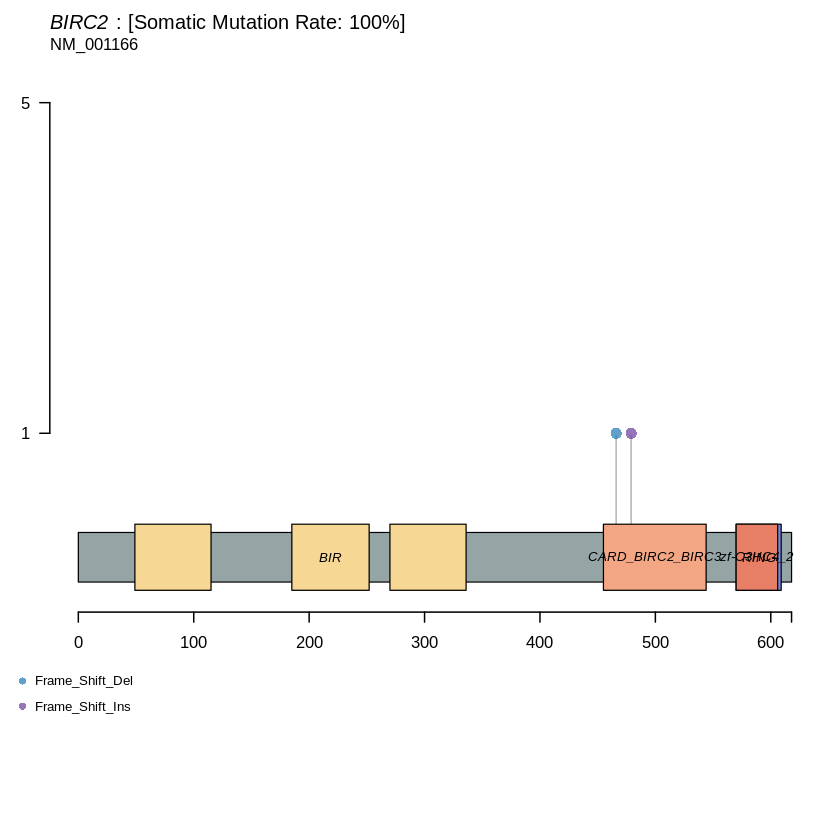

In [14]:
%%R
lollipopPlot(
  maf = maf_1,
  repel = TRUE,
  gene = 'BIRC2',
  AACol = 'Protein_Change',
  showMutationRate = TRUE)

In [11]:
%%R 
maf_1@data %>% 
    select(Hugo_Symbol,Tumor_Sample_Barcode,Variant_Classification,Variant_Type,tumor_f)

Hugo_Symbol,Tumor_Sample_Barcode,Variant_Classification,Variant_Type,tumor_f
<chr>,<fct>,<fct>,<fct>,<dbl>
NFKB2,MM01,Splice_Site,DEL,0.674
BIRC3,MM01,Splice_Site,INS,0.941
BIRC2,MM01,Frame_Shift_Del,DEL,0.017
BIRC2,MM01,Frame_Shift_Ins,INS,0.043
TRAF3,MM01,Splice_Site,INS,0.964
TRAF3,MM01,Splice_Site,INS,0.856
MAP3K14,MM01,Splice_Site,DEL,0.776


In [12]:
%%R 

maf_2@data %>% 
    select(Hugo_Symbol,Tumor_Sample_Barcode,Variant_Classification,Variant_Type,tumor_f)

Hugo_Symbol,Tumor_Sample_Barcode,Variant_Classification,Variant_Type,tumor_f
<chr>,<fct>,<fct>,<fct>,<dbl>
NFKB2,MM03,Splice_Site,DEL,0.629
NFKB2,MM03,Splice_Site,DEL,0.709


png 
  2

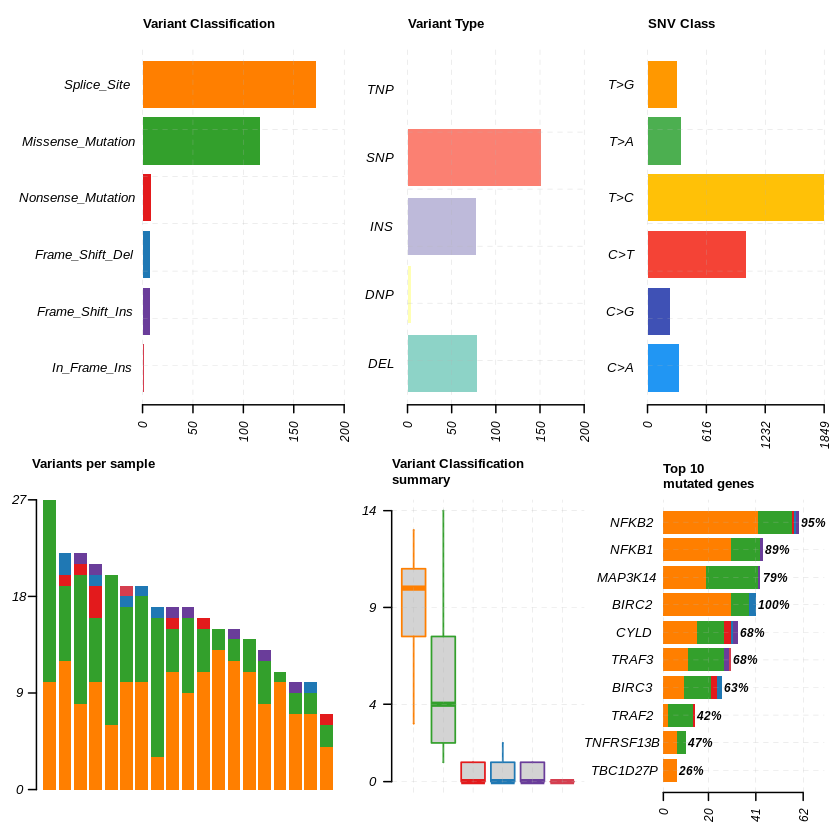

In [10]:
%%R

plotmafSummary(maf = xmafs)
pdf(file = "plot/RJVX01.FullSummary.pdf",width = 10, height = 7)
plotmafSummary(maf = xmafs, textSize = 6)
dev.off()

png 
  2

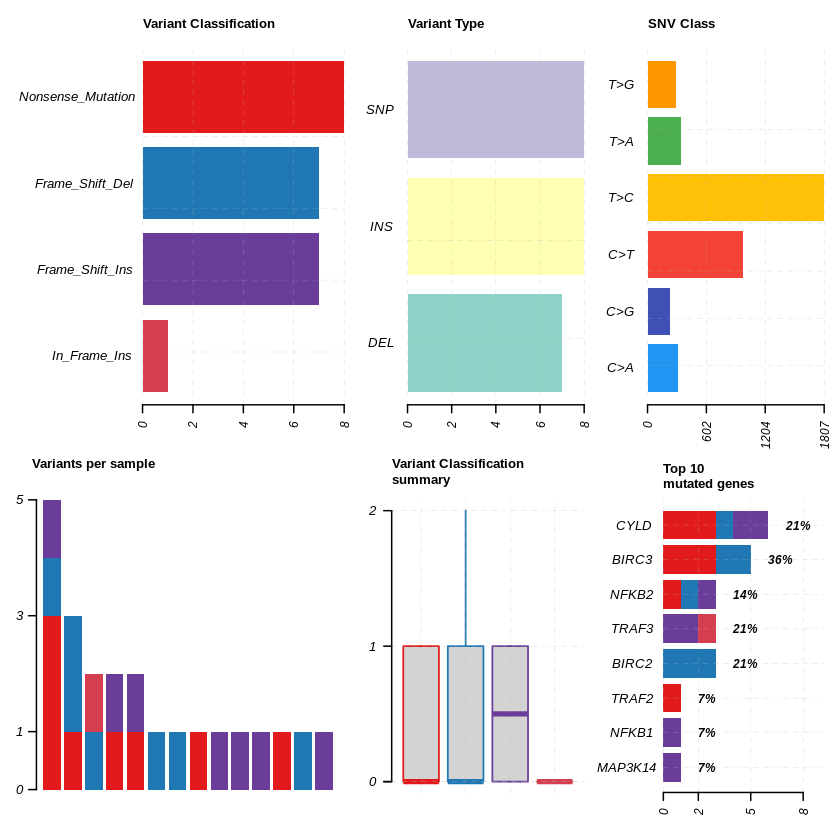

In [11]:
%%R 

plotmafSummary(maf = ymafs)
pdf(file = "plot/RJVX01.Summary.pdf",width = 10, height = 7)
plotmafSummary(maf = ymafs, textSize = 6)
dev.off()

png 
  2

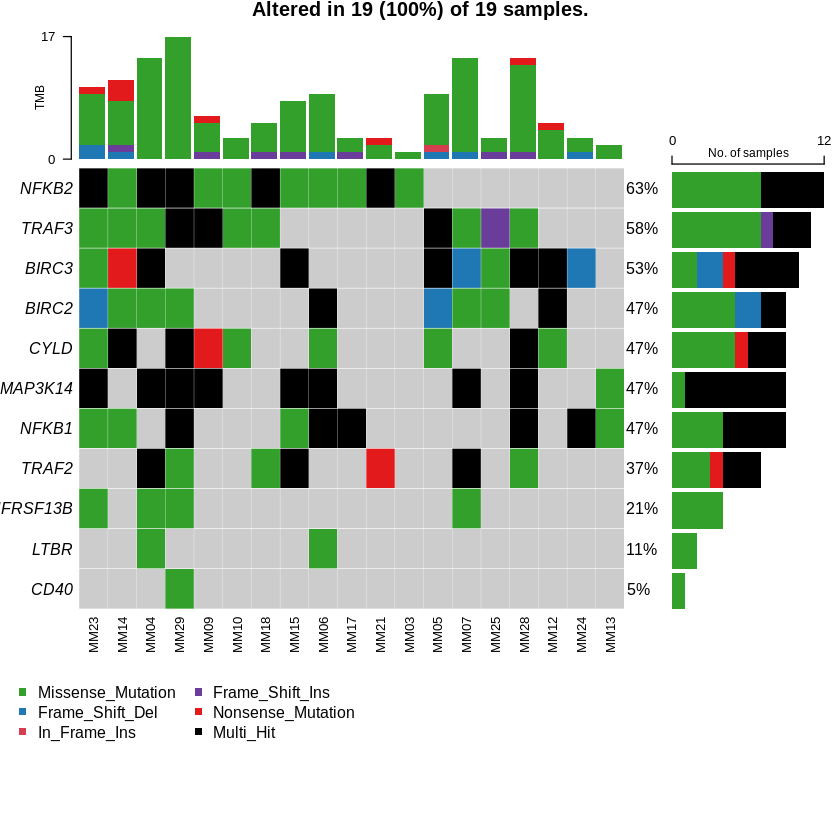

In [27]:
%%R 
oncoplot(maf = ymafs, showTumorSampleBarcodes = TRUE)
pdf(file = "plot/RJVX01.FullOncoplot.pdf",width = 10, height = 7)
oncoplot(maf = ymafs, showTumorSampleBarcodes = TRUE)
dev.off()

png 
  2

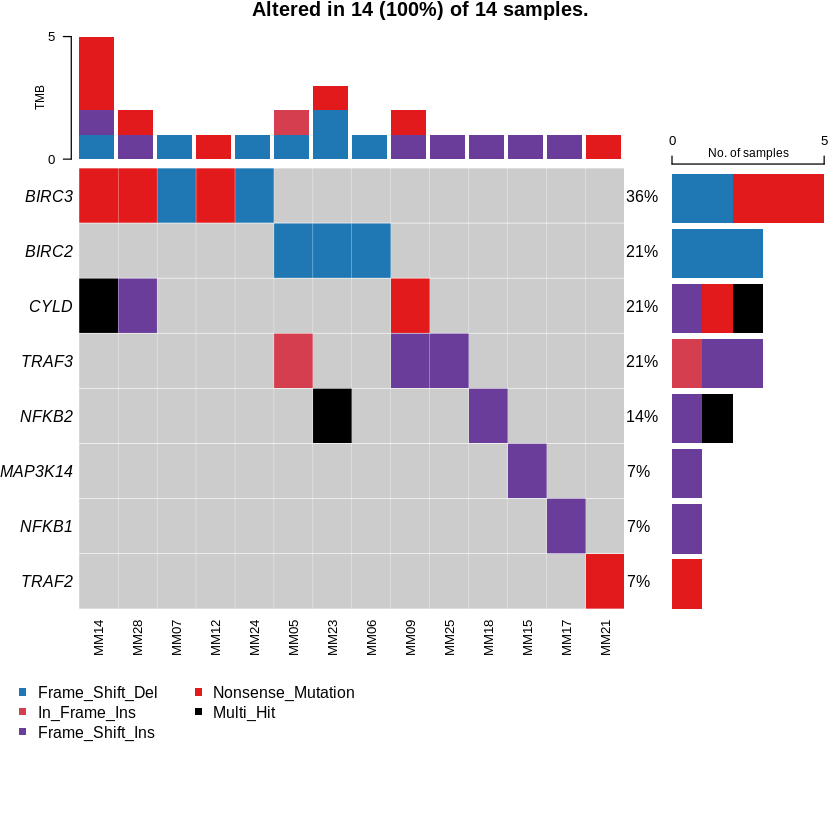

In [12]:
%%R 

oncoplot(maf = ymafs, showTumorSampleBarcodes = TRUE)
pdf(file = "plot/RJVX01.Oncoplot.pdf",width = 10, height = 7)
oncoplot(maf = ymafs, showTumorSampleBarcodes = TRUE)
dev.off()

png 
  2

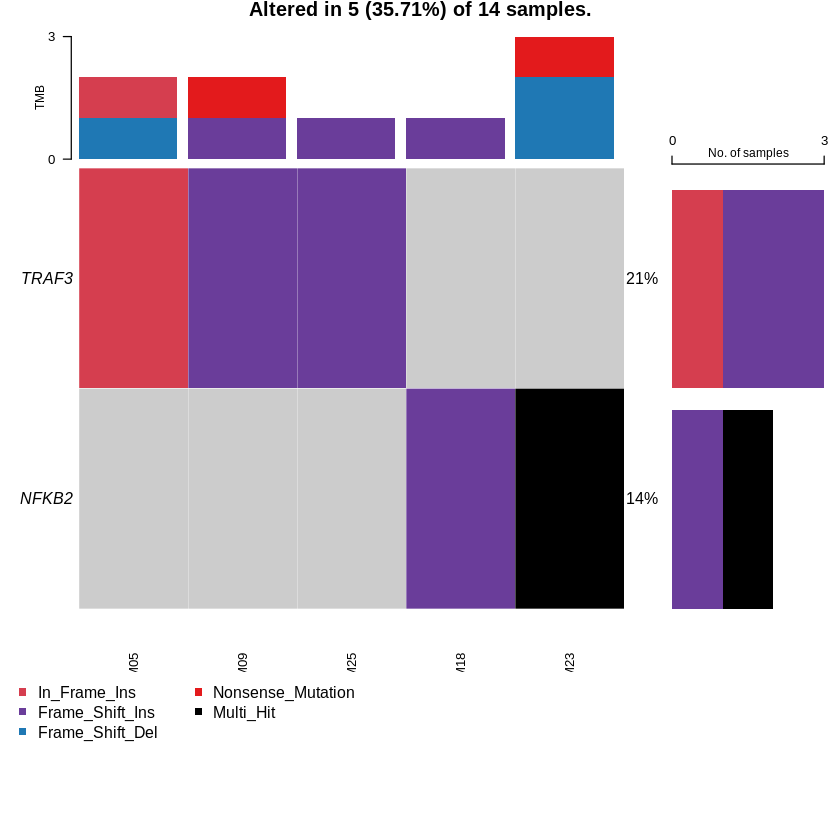

In [315]:
%%R 

oncoplot(maf = ymafs, showTumorSampleBarcodes = TRUE, genes = c("TRAF3","NFKB2"))
pdf(file = "plot/RJVX01.Oncoplot_TRAF3_p52.pdf",width = 10, height = 7)
oncoplot(maf = ymafs, showTumorSampleBarcodes = TRUE, genes = c("TRAF3","NFKB2"))
dev.off()

gene1,gene2,pValue,oddsRatio,00,11,01,10,Event,pair,event_ratio
<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<chr>,<chr>,<chr>
BIRC3,BIRC2,0.2582418,0.000000,6,0,3,5,Mutually_Exclusive,"BIRC2, BIRC3",0/8
BIRC3,TRAF3,0.2582418,0.000000,6,0,3,5,Mutually_Exclusive,"BIRC3, TRAF3",0/8
NFKB2,BIRC2,0.3956044,4.281751,10,1,2,1,Co_Occurence,"BIRC2, NFKB2",1/3
CYLD,BIRC3,0.5054945,4.648875,8,2,3,1,Co_Occurence,"BIRC3, CYLD",2/4
NFKB2,BIRC3,0.5054945,0.000000,7,0,5,2,Mutually_Exclusive,"BIRC3, NFKB2",0/7
MAP3K14,BIRC3,1.0000000,0.000000,8,0,5,1,Mutually_Exclusive,"BIRC3, MAP3K14",0/6
NFKB1,BIRC3,1.0000000,0.000000,8,0,5,1,Mutually_Exclusive,"BIRC3, NFKB1",0/6
TRAF2,BIRC3,1.0000000,0.000000,8,0,5,1,Mutually_Exclusive,"BIRC3, TRAF2",0/6
CYLD,BIRC2,1.0000000,0.000000,8,0,3,3,Mutually_Exclusive,"BIRC2, CYLD",0/6


gene1,gene2,pValue,oddsRatio,00,11,01,10,Event,pair,event_ratio
<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<chr>,<chr>,<chr>
BIRC3,BIRC2,0.2582418,0.000000,6,0,3,5,Mutually_Exclusive,"BIRC2, BIRC3",0/8
BIRC3,TRAF3,0.2582418,0.000000,6,0,3,5,Mutually_Exclusive,"BIRC3, TRAF3",0/8
NFKB2,BIRC2,0.3956044,4.281751,10,1,2,1,Co_Occurence,"BIRC2, NFKB2",1/3
CYLD,BIRC3,0.5054945,4.648875,8,2,3,1,Co_Occurence,"BIRC3, CYLD",2/4
NFKB2,BIRC3,0.5054945,0.000000,7,0,5,2,Mutually_Exclusive,"BIRC3, NFKB2",0/7
MAP3K14,BIRC3,1.0000000,0.000000,8,0,5,1,Mutually_Exclusive,"BIRC3, MAP3K14",0/6
NFKB1,BIRC3,1.0000000,0.000000,8,0,5,1,Mutually_Exclusive,"BIRC3, NFKB1",0/6
TRAF2,BIRC3,1.0000000,0.000000,8,0,5,1,Mutually_Exclusive,"BIRC3, TRAF2",0/6
CYLD,BIRC2,1.0000000,0.000000,8,0,3,3,Mutually_Exclusive,"BIRC2, CYLD",0/6


png 
  2

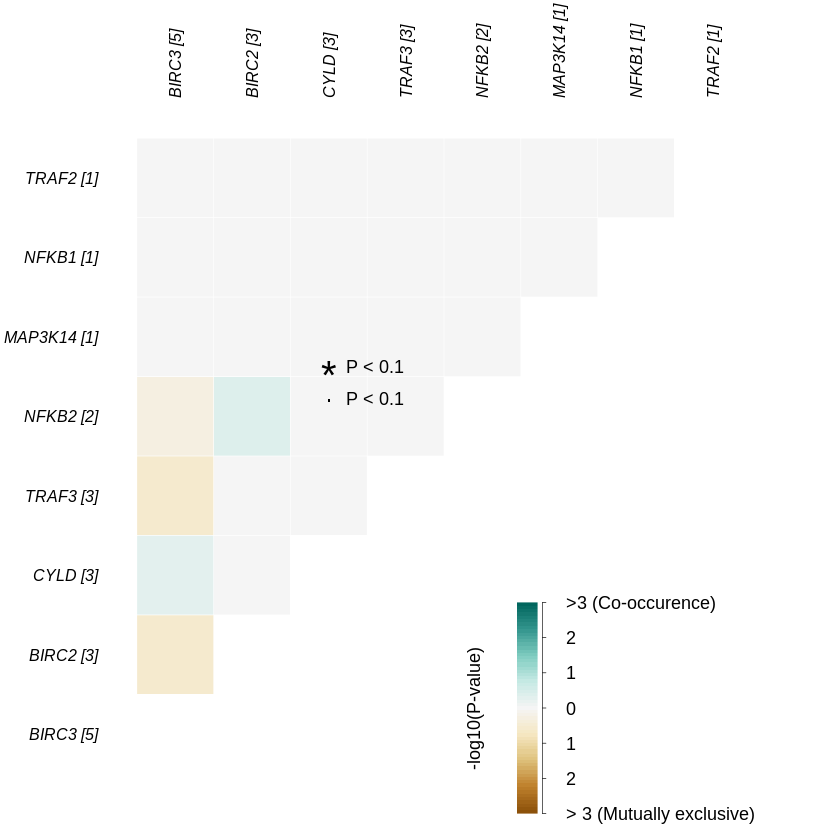

In [314]:
%%R 

somaticInteractions(maf = ymafs, top = 25, pvalue = 0.1)
pdf(file = "plot/RJVX01.Interactions.pdf",width = 10, height = 7)
somaticInteractions(maf = ymafs, top = 25, pvalue = 0.1)
dev.off()

3 transcripts available. Use arguments refSeqID or proteinID to manually specify tx name.



    HGNC    refseq.ID   protein.ID aa.length
1: NFKB2 NM_001077494 NP_001070962       900
2: NFKB2 NM_001261403 NP_001248332       899
3: NFKB2    NM_002502    NP_002493       899


Using longer transcript NM_001077494 for now.

3 transcripts available. Use arguments refSeqID or proteinID to manually specify tx name.



    HGNC    refseq.ID   protein.ID aa.length
1: NFKB2 NM_001077494 NP_001070962       900
2: NFKB2 NM_001261403 NP_001248332       899
3: NFKB2    NM_002502    NP_002493       899


Using longer transcript NM_001077494 for now.



png 
  2

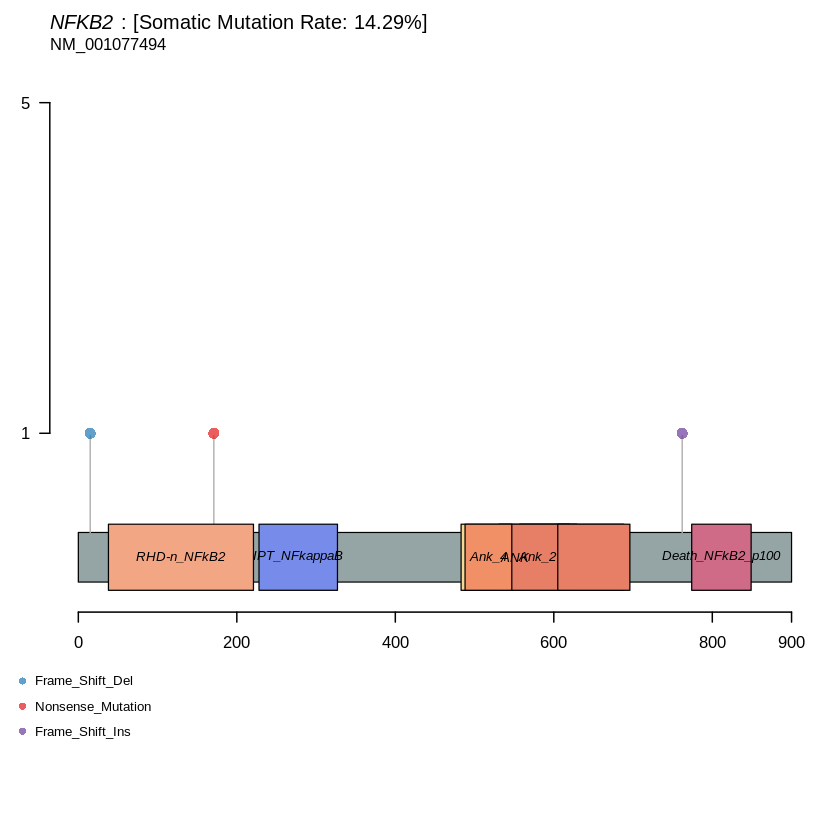

In [323]:
%%R 

lollipopPlot(
  maf = ymafs,
  repel = TRUE,
  gene = 'NFKB2',
  AACol = 'Protein_Change',
  showMutationRate = TRUE)
pdf(file = "plot/RJVX01.Lollipop_NFKB2.pdf",width = 16, height = 9)
lollipopPlot(
  maf = ymafs,
  repel = TRUE,
  gene = 'NFKB2',
  AACol = 'Protein_Change',
  showMutationRate = TRUE)
dev.off()

4 transcripts available. Use arguments refSeqID or proteinID to manually specify tx name.



    HGNC    refseq.ID   protein.ID aa.length
1: TRAF3 NM_001199427 NP_001186356       485
2: TRAF3    NM_003300    NP_003291       568
3: TRAF3    NM_145725    NP_663777       568
4: TRAF3    NM_145726    NP_663778       543


Using longer transcript NM_003300 for now.

4 transcripts available. Use arguments refSeqID or proteinID to manually specify tx name.



    HGNC    refseq.ID   protein.ID aa.length
1: TRAF3 NM_001199427 NP_001186356       485
2: TRAF3    NM_003300    NP_003291       568
3: TRAF3    NM_145725    NP_663777       568
4: TRAF3    NM_145726    NP_663778       543


Using longer transcript NM_003300 for now.



png 
  2

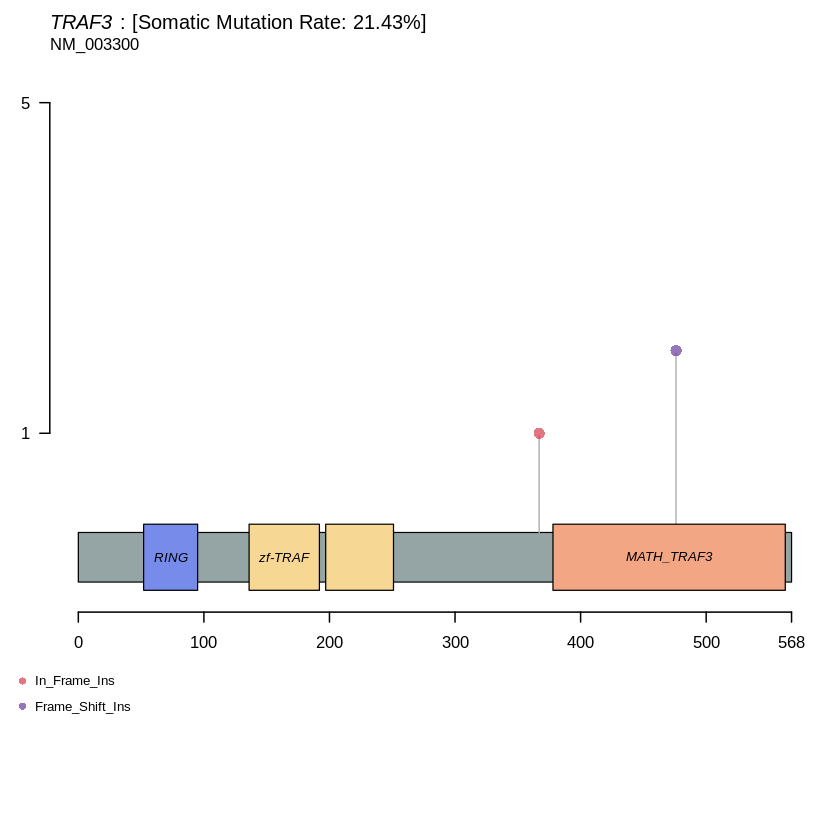

In [324]:
%%R 

lollipopPlot(
  maf = ymafs,
  repel = TRUE,
  gene = 'TRAF3',
  AACol = 'Protein_Change',
  showMutationRate = TRUE)
pdf(file = "plot/RJVX01.Lollipop_TRAF3.pdf",width = 16, height = 9)
lollipopPlot(
  maf = ymafs,
  repel = TRUE,
  gene = 'TRAF3',
  AACol = 'Protein_Change',
  showMutationRate = TRUE)
dev.off()

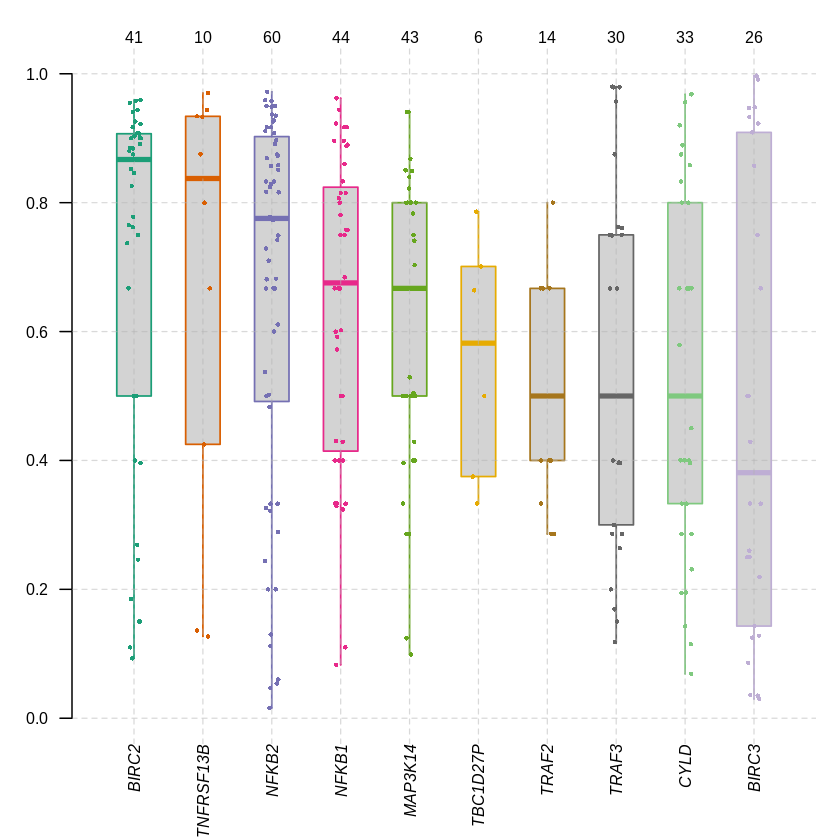

In [325]:
%%R 

plotVaf(maf = xmafs, vafCol = 'tumor_f')

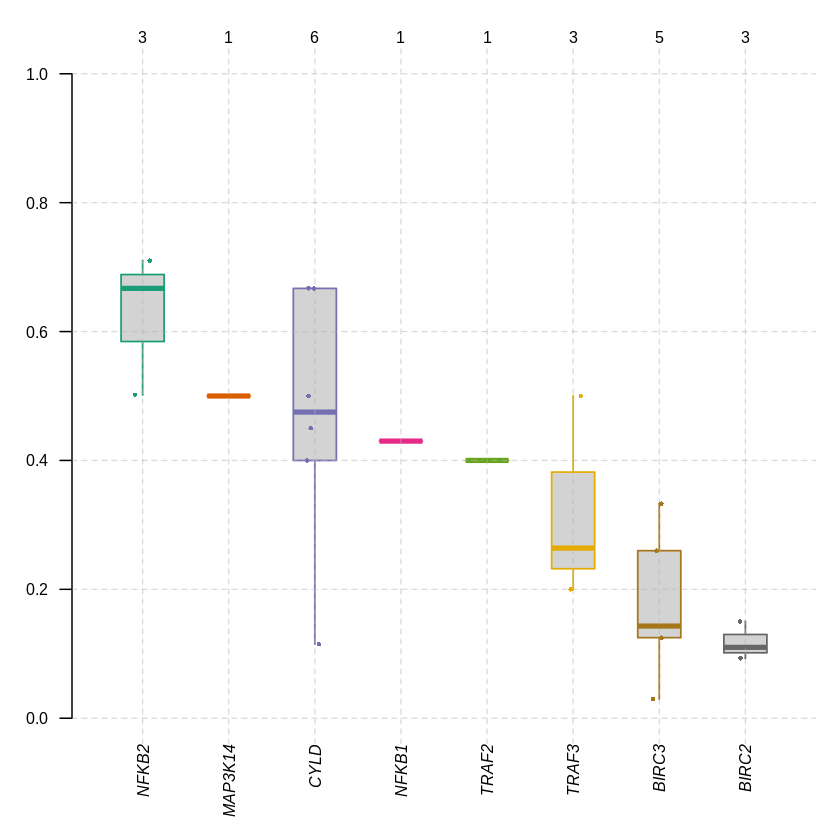

In [326]:
%%R 

plotVaf(maf = ymafs, vafCol = 'tumor_f')

HGNC,AAPos,Variant_Classification,N,total,fraction,DomainLabel,pfam,Description
<chr>,<dbl>,<fct>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>
BIRC2,527,Frame_Shift_Del,2,3,0.6666667,CARD_BIRC2_BIRC3,cd08329,"Caspase activation and recruitment domain found in Baculoviral IAP repeat-containing proteins, BIRC2 (c-IAP1) and BIRC3 (c-IAP2)"
TRAF3,476,Frame_Shift_Ins,2,3,0.6666667,MATH_TRAF3,TRAF molecules serve as adapter proteins that link TNFRs and downstream kinase cascades resulting in the activation of transcription factors and the...,"Tumor Necrosis Factor Receptor (TNFR)-Associated Factor (TRAF) family, TRAF3 subfamily, TRAF domain"
BIRC2,544,Frame_Shift_Del,1,3,0.3333333,CARD_BIRC2_BIRC3,cd08329,"Caspase activation and recruitment domain found in Baculoviral IAP repeat-containing proteins, BIRC2 (c-IAP1) and BIRC3 (c-IAP2)"
BIRC3,295,Frame_Shift_Del,1,5,0.2000000,BIR,"Found in inhibitors of apoptosis proteins (IAPs) and other proteins. In higher eukaryotes, BIR domains inhibit apoptosis by acting as direct inhibitors of the caspase family of protease enzymes",Baculoviral inhibition of apoptosis protein repeat domain
BIRC3,494,Nonsense_Mutation,1,5,0.2000000,CARD_BIRC2_BIRC3,cd08329,"Caspase activation and recruitment domain found in Baculoviral IAP repeat-containing proteins, BIRC2 (c-IAP1) and BIRC3 (c-IAP2)"
BIRC3,294,Nonsense_Mutation,1,5,0.2000000,BIR,"Found in inhibitors of apoptosis proteins (IAPs) and other proteins. In higher eukaryotes, BIR domains inhibit apoptosis by acting as direct inhibitors of the caspase family of protease enzymes",Baculoviral inhibition of apoptosis protein repeat domain
CYLD,906,Nonsense_Mutation,1,6,0.1666667,Peptidase_C19N,cd02670,A subfamily of Peptidase C19. Peptidase C19 contains ubiquitinyl hydrolases. They are intracellular peptidases that remove ubiquitin molecules from polyubiquinated peptides by cleavage of isopeptide bonds. They hydrolyze bonds involving the carboxyl...
CYLD,184,Nonsense_Mutation,1,6,0.1666667,CAP_GLY,smart01052,Cytoskeleton-associated proteins (CAPs) are involved in the organisation of microtubules and transportation of vesicles and organelles along the cytoskeletal network
CYLD,257,Nonsense_Mutation,1,6,0.1666667,CAP_GLY,pfam01302,CAP-Gly domain


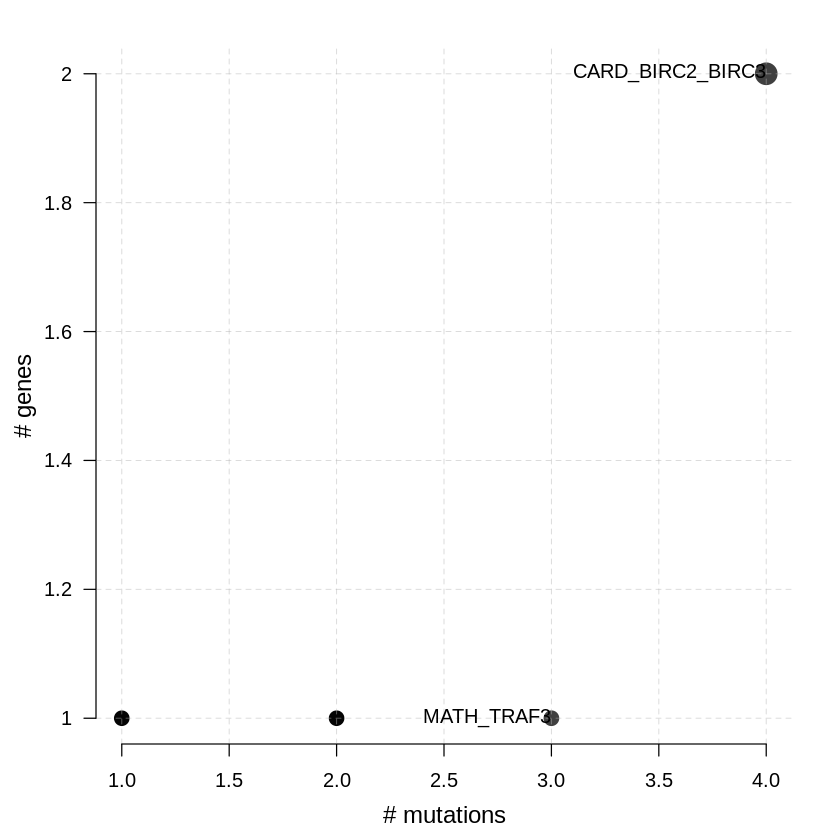

In [327]:
%%R 

pfamDomains(maf = ymafs, AACol = 'Protein_Change', top = 2, summarizeBy = "AAPos")

In [328]:
%%R 

clinEnrich = clinicalEnrichment(maf = ymafs, annotationDat = xclin, clinicalFeature = "class", minMut = 0)

Sample size per factor in class:




 0  1 
 7 12 
